# Quantum representations of classical data tutorial

## Table of contents
- Qubit Lattice
- FRQI
- MCRQI

Information is an abstract concept that refers to something which has the *potential* to inform. Images are a kind of classical data which convey visual information. Operating with information may allow us to obtain *more* information. 

Information can be represented in an infinite number of ways, some useful, some not. 

Images are often represented using the RGB model, where one has three independent matrices, one for each primary color. But there also exists the HSI model, which represents and image via the hue, saturation and intensity.

It is pretty obvious that both of this representations are better suited, more efficient, to *inform* about the contents of an image compared to a flattened representation, despite containing essentially the same information.

In the quantum realm the same thing happens. With the added complication that we work with a less intuitive paradigm. 

In this tutorial we'll focus on images

QC in 3 lines.


Qubits are fancy bits. Bits are like a switch, qubits are like a fancy switch which can be correlated in a way simple switches cannot. As with bits, we have logical gates for fancy bits, aka qubits.

Fancy switches are a bit picky so they are vulnerable to noise and change their behaviour once you look at them.

In [1]:
import qiskit
import qiskit_aer
import numpy as np
import qiskit.quantum_info
import utils
from metrics import compute_ssim
from math import log

# Introduction to QC with Qiskit

In [2]:
# Registers
n_qubits = 5
n_bits   = 5

qReg = qiskit.QuantumRegister(n_qubits, "qReg") 
cReg = qiskit.ClassicalRegister(n_bits, 'cReg')

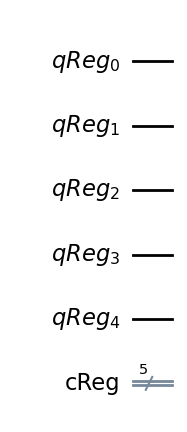

In [3]:
# Circuit
#   - a circuit is composed by registers
circuit = qiskit.QuantumCircuit(qReg, cReg)

circuit.draw(output='mpl')

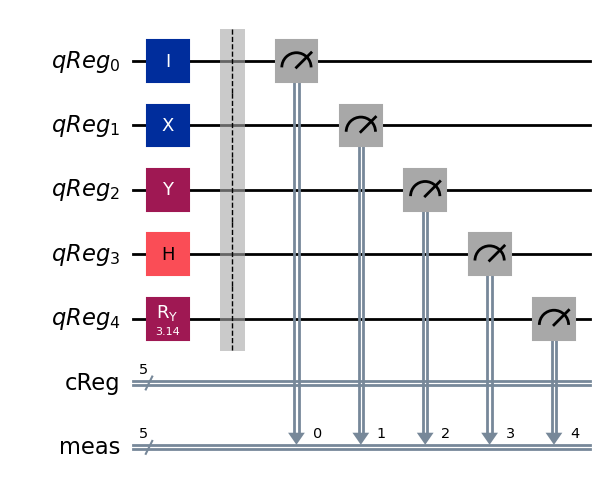

In [4]:
# Gates
#   - we can place gates in each register to do operations
circuit.id(0)
circuit.x(1)
circuit.y(2)
circuit.h(3)
circuit.ry(3.1415, 4)
circuit.measure_all()
circuit.draw(output='mpl')


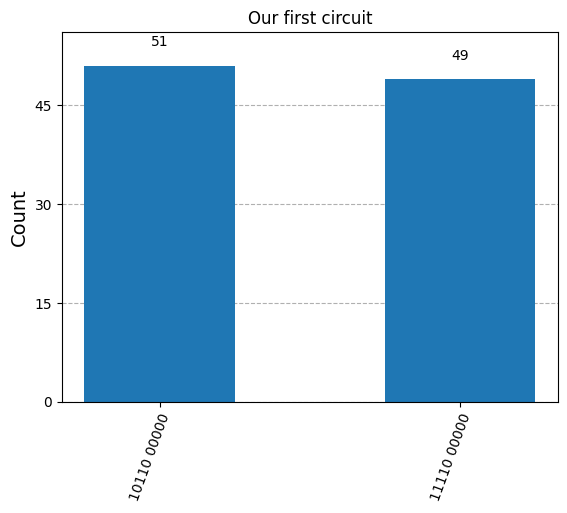

In [5]:
import qiskit.visualization


simulator = qiskit_aer.AerSimulator()
circuit = qiskit.transpile(circuit, simulator)

result = simulator.run(circuit, shots=100).result()
counts = result.get_counts(circuit)

qiskit.visualization.plot_histogram(counts, title="Our first circuit")

# Qubit lattice

The simplest way we can represent an image is via the *Qubit Lattice Representation*. As you will see this is a very non-efficient method but serves as a very good introduction point for quantum representations of images.

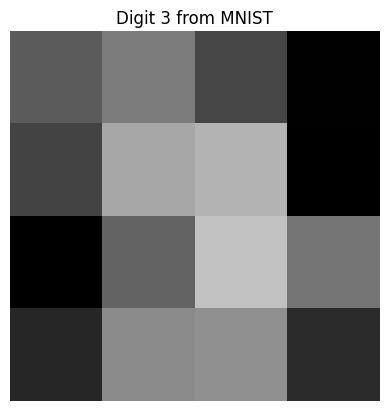

In [6]:
image = utils.plot_image('images/three_4by4.jpg', 'Digit 3 from MNIST')

Before encoding our image first we'll transform it into an flattened-angle representation. To do so, first we'll flatten the image into a vector and then interpolate the pixel intensities to angles between zero and pi. Since we'll use rotation gates it makes more sense to convert things to angles.

We store the angle representation of each pixel in each qubit and then measure all qubits.

In [7]:
def build_qubit_lattice(image):
    flat_ang_representation = utils.get_angle_representation(image, 
                                                         min_val=0, 
                                                         max_val=255)
    n_pixels = len(flat_ang_representation)
    quantumPixelReg = qiskit.QuantumRegister(n_pixels, 'Quantum Pixel')
    classicalPixelReg = qiskit.ClassicalRegister(n_pixels, 'Classical Pixel')
    qubit_lattice = qiskit.QuantumCircuit(quantumPixelReg, classicalPixelReg)

    for idx, angle in enumerate(flat_ang_representation):
        qubit_lattice.ry(angle, idx)
        qubit_lattice.measure(idx, idx)
        
    return qubit_lattice

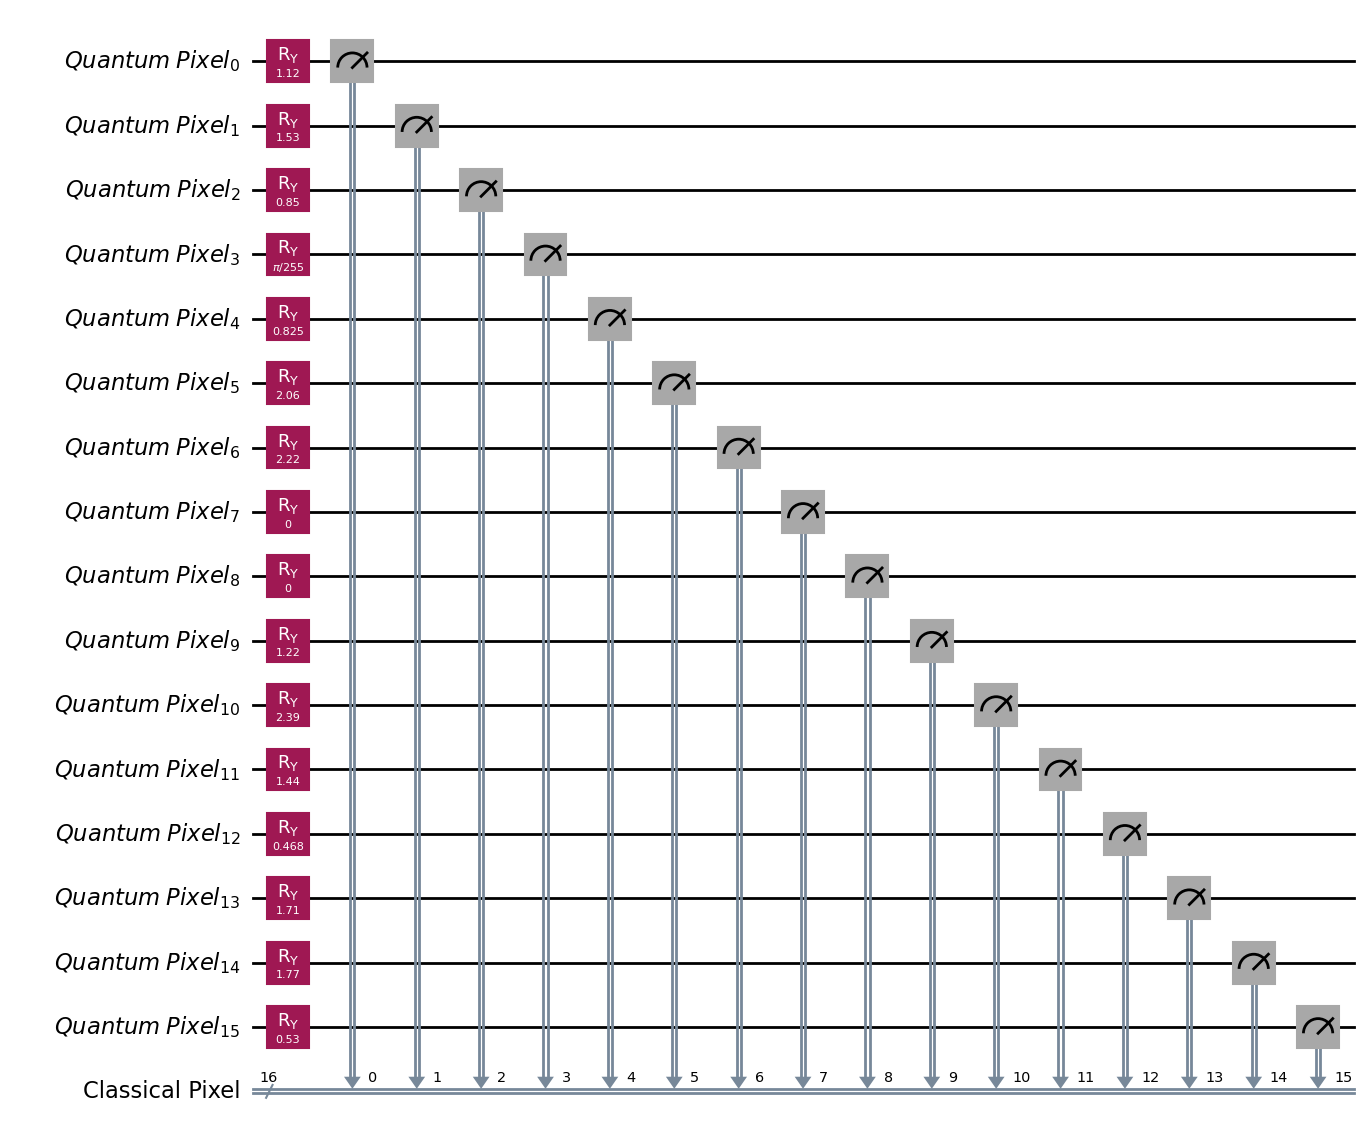

In [8]:
qubit_lattice = build_qubit_lattice(image)
qubit_lattice.draw(output="mpl")

## Scalability

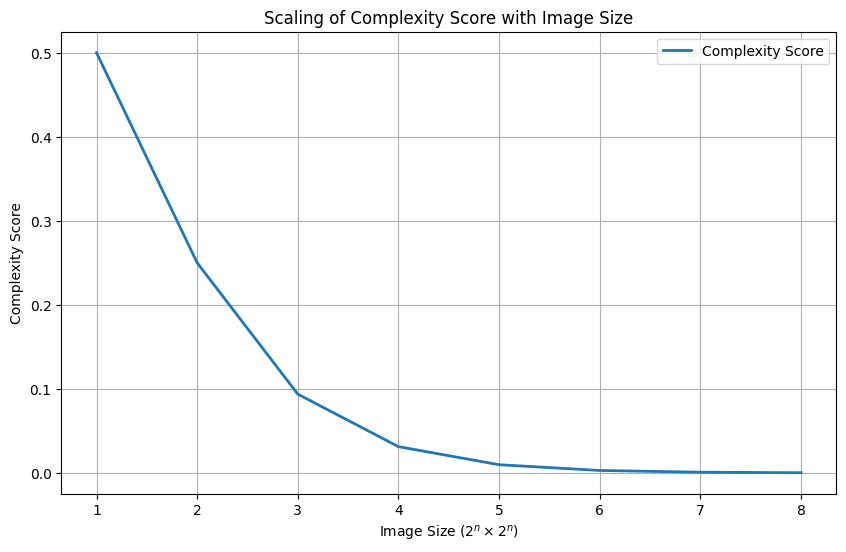

In [9]:
qubit_lattice_scaling = utils.plot_scalability(build_qubit_lattice)

In [10]:
import csv

# Writing as a single row
with open('data/qubit_lattice.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(qubit_lattice_scaling)

## Retrieval

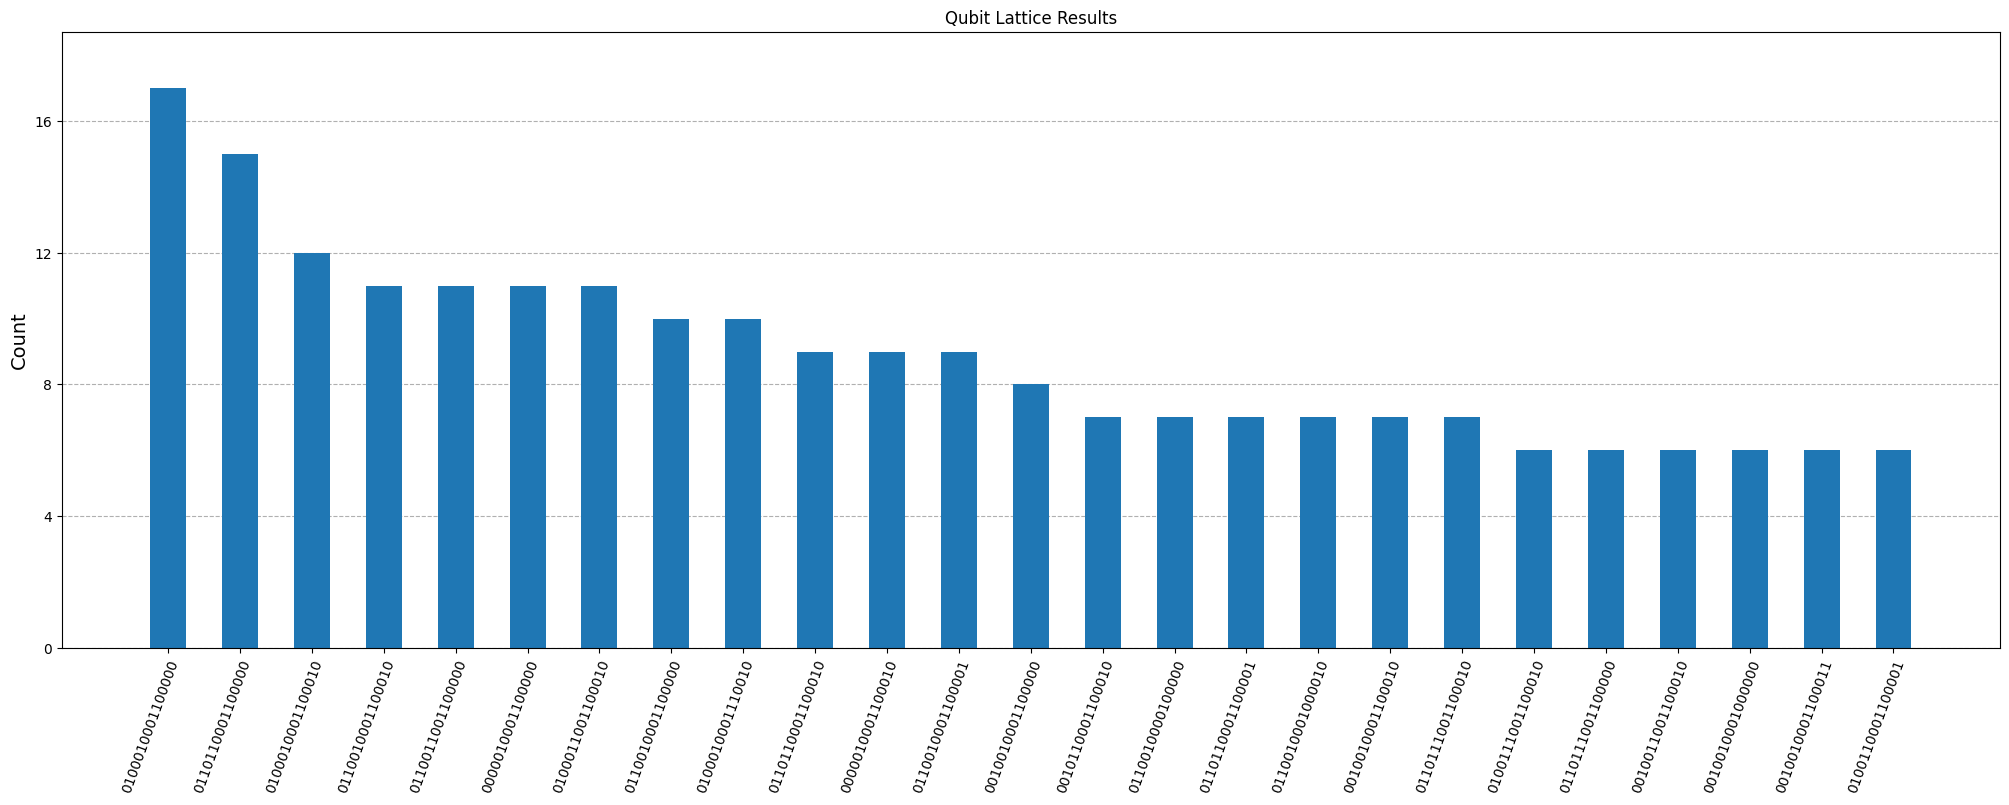

In [11]:
simulator = qiskit_aer.AerSimulator()
circuit = qiskit.transpile(qubit_lattice, simulator)
shots = 1000
result = simulator.run(circuit, shots=shots).result()
counts = result.get_counts(circuit)
qiskit.visualization.plot_histogram(counts, figsize=(25, 8), sort="value_desc", title="Qubit Lattice Results", bar_labels=False, number_to_keep=25)

In [12]:
# To reconstruct the image we collect the results from all shots
values = np.zeros(qubit_lattice.num_qubits)
for item in counts:
    for i, bit in enumerate(item):
        if bit=='0':
            values[i]+=counts[item]

values = values/shots

reconstruct = []
for pixel in values:
    color = 2*np.arccos((pixel)**(1/2)) # "shots" corresponds to the total counts value.
    reconstruct.append(color)

TypeError: Invalid shape (16,) for image data

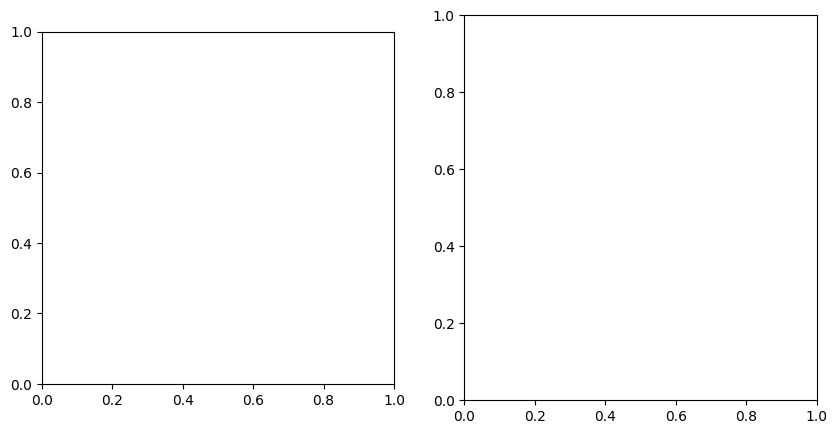

In [13]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(reconstruct, cmap='gray', vmin=0, vmax=255)
axs[0].set_title('Reconstructed Image')
axs[1].imshow(image, cmap='gray', vmin=0, vmax=255)
axs[1].set_title('Original Image')

plt.tight_layout()

# FRQI
*Flexible representation of quantum images.*

$$|I(\theta)\rangle = \frac 1 {2^n}\sum$$

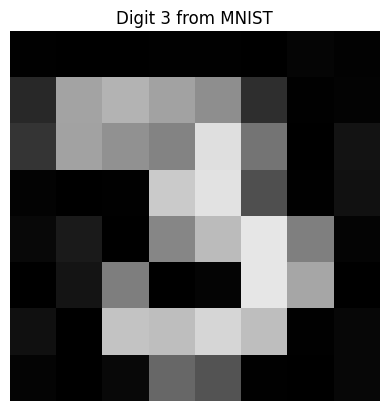

In [36]:
image = utils.plot_image('images/three_8by8.jpg', 'Digit 3 from MNIST')

The FRQI encoding consist of three broad steps:
1. Equal weighted superposition of all qubits (to be able to access all $2^n$ amplitudes??).
2. Iterative application of $X$ gates to dictate on which pixel (amplitude) we are working on.
3. Application of multi-controlled rotation gates to encode the pixel intensities.

In [37]:
def equal_superposition(circ: qiskit.QuantumCircuit):
    n_qubits = circ.num_qubits
    for idx in range(n_qubits):
        circ.h(idx)
        
def iterate(circ: qiskit.QuantumCircuit, current_state: str, next_state: str):
    n = len(current_state)
    
    # Indices we must apply an X gate to go from current_state to next_state 
    x_targets = [idx for idx in range(n) if current_state[idx] != next_state[idx]]

    if x_targets:
        circ.x(x_targets)

def pixel_encoding(circ: qiskit.QuantumCircuit, control: list, target: int, intensity: float):
    circ.mcry(theta = 2 * intensity,
              q_controls = control,
              q_target = target)

In [38]:
def construct_frqi(circ: qiskit.QuantumCircuit, control: list, 
                   target: qiskit.QuantumRegister, image: np.array):
    
    equal_superposition(circ)
    num_qubits = circ.num_qubits
            
    for idx, angle in enumerate(image):
        # We make a binary string representation of `idx``
        #   of length `num_qubits`.
        state = '{0:0{1}b}'.format(idx-1, num_qubits) 
        next_state = '{0:0{1}b}'.format(idx, num_qubits)
        
        if idx > 0:
            iterate(circ, state, next_state)
        
        pixel_encoding(circ, control, target, angle)
        circ.barrier()
    
    to_measure = [*range(num_qubits)]
    circ.measure(to_measure, to_measure)

In [39]:
flat_ang_rep = utils.get_angle_representation(image,
                                                min_val=0,
                                                max_val=255)
n = log(image.shape[0], 2)
required_qubits = int(2*n+1)
qRegCord = qiskit.QuantumRegister(required_qubits, 'coordinates') # 2n -> 2 * 3 = 6
qRegColor = qiskit.QuantumRegister(1, 'color') # We add an extra qubit to encode the color.
cReg = qiskit.ClassicalRegister(qRegCord.size+qRegColor.size, 'bits')

In [40]:
frqi_circ = qiskit.QuantumCircuit(qRegCord, qRegColor, cReg)

In [41]:
construct_frqi(frqi_circ, list(qRegCord), qRegColor[0], flat_ang_rep)

/Users/uribagi/Documents/PhD/CVC/quantum-representations-of-classical-data/qrep-env/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/uribagi/Documents/PhD/CVC/quantum-representations-of-classical-data/qrep-env/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [42]:
print(frqi_circ.depth())
print(frqi_circ.num_qubits)

577
8


In [43]:
#frqi_circ.draw(output='mpl')

## Scalability

In [22]:
[2*n+1 for n in range(1,11)]

[3, 5, 7, 9, 11, 13, 15, 17, 19, 21]

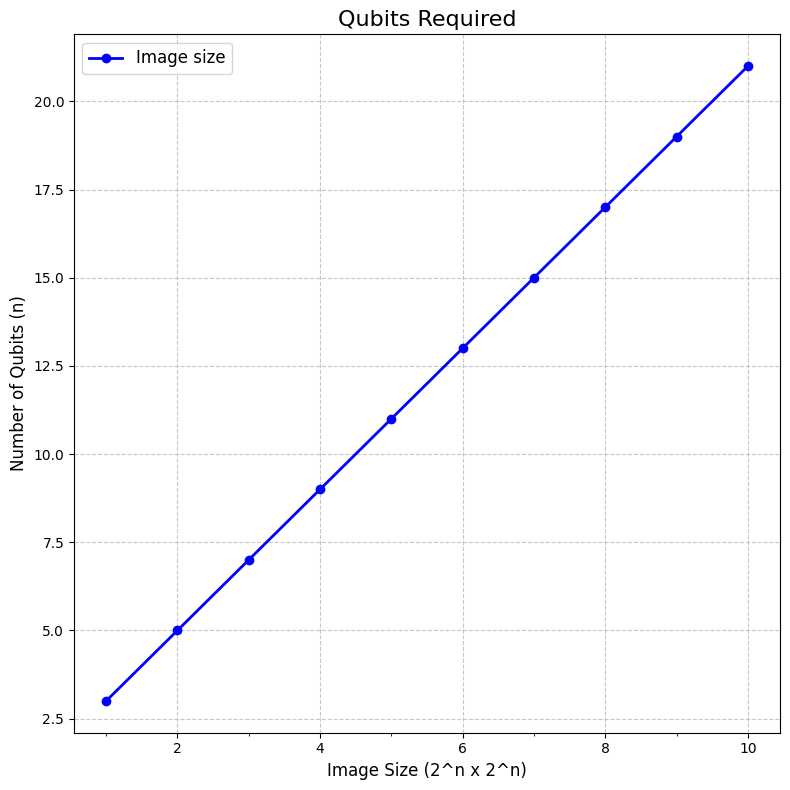

In [23]:
qubits_required = [2*n+1 for n in range(1,11)]
metrics = [qubits_required]

utils.line_plot("Qubits Required", metrics, ["Image size"], "Image Size (2^n x 2^n)", "Number of Qubits (n)")

## Retrieval

In [45]:
simulator = qiskit_aer.AerSimulator()
circuit = qiskit.transpile(frqi_circ, simulator)
shots = 102400
result = simulator.run(circuit, shots=shots).result()

In [ ]:
retrieve_image = np.array([])

for i in range(64):
  try:
    s = format(i, '07b')
    new_s = '1' + s
    retrieve_image = np.append(retrieve_image,np.sqrt(result.get_counts(circuit)[new_s]/shots))
  except KeyError:
    retrieve_image = np.append(retrieve_image,[0.0])
    
retrieve_image *=  8.0*255.0
retrieve_image = retrieve_image.astype('int')
retrieve_image = retrieve_image.reshape((8,8))

print(retrieve_image)
print(image)

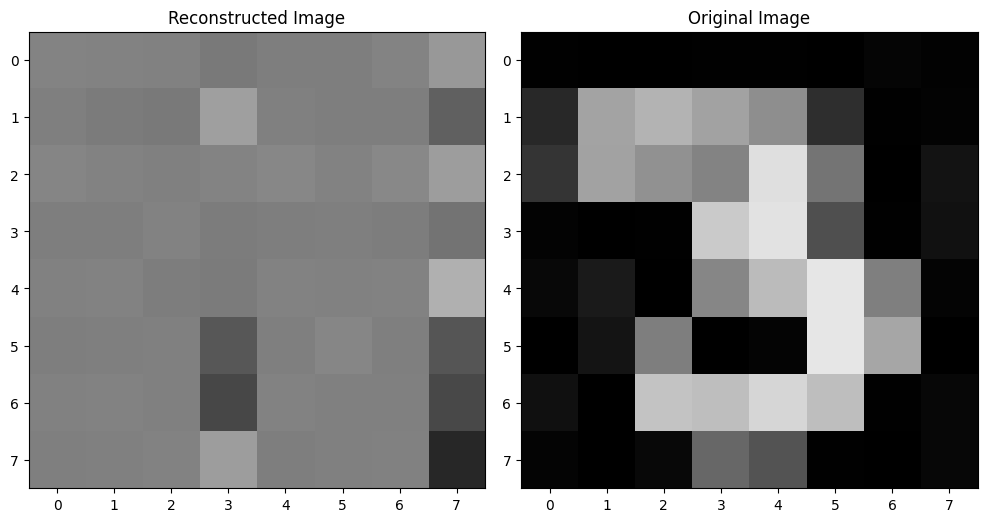

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(retrieve_image, cmap='gray', vmin=0, vmax=255)
axs[0].set_title('Reconstructed Image')
axs[1].imshow(image, cmap='gray', vmin=0, vmax=255)
axs[1].set_title('Original Image')

plt.tight_layout()

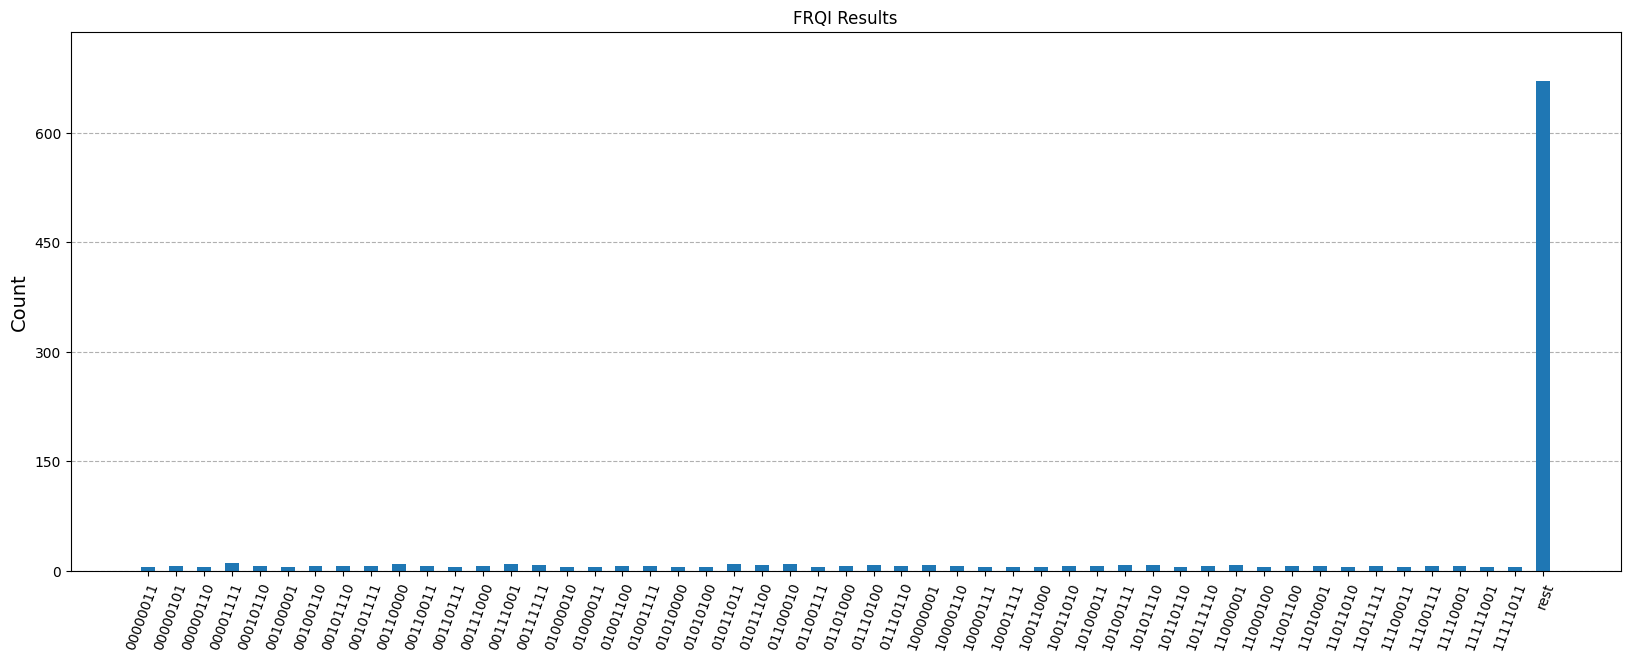

In [29]:
counts = result.get_counts(circuit)
qiskit.visualization.plot_histogram(counts, figsize=(20, 7), title="FRQI Results", bar_labels=False, number_to_keep=50)

# MCRQI

This encoding allows us to use multiple channels, therefore we can now encode RGB images.

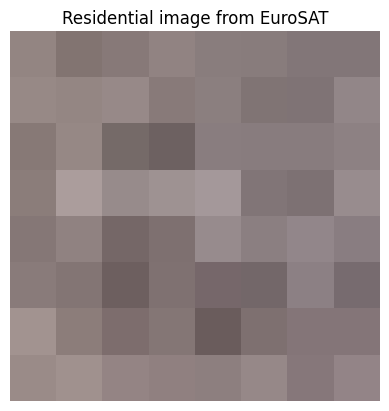

In [51]:
image = utils.plot_image("images/residential_8by8by3.jpg", "Residential image from EuroSAT", rgb=True)

In [ ]:
from qiskit.circuit.library.standard_gates.ry import RYGate

def build_mcrqi(image):
    xqbits = log(image.shape[0], 2)
    yqbits = log(image.shape[1], 2)
    
    # We only store the coordinates "for one channel"
    coord_qbits = int(xqbits) + int(yqbits)
    
    qr = qiskit.QuantumRegister(coord_qbits + 3)
    cr = qiskit.ClassicalRegister(coord_qbits + 3, 'c')
    qc = qiskit.QuantumCircuit(qr, cr)

    # USED FOR TRANSPOSED IMAGES
    for k in range(int(np.floor(coord_qbits/2))):
        qc.swap(k,coord_qbits - 1 - k)

    for i in range(coord_qbits):
        qc.h(i)

    for layer_num, input_im in enumerate(image.T): # loop for iterating R,G,B channels
        input_im = input_im.flatten() # flatten the image to 1-D
        input_im = np.interp(input_im, (0, 255), (0, np.pi/2)) # convert the color value into angles

        for i, pixel in enumerate(input_im):
            arr = list(range(coord_qbits)) # control qubits
            arr.append(int(coord_qbits + layer_num)) # target qubit application
            cMry = RYGate(2*pixel).control(coord_qbits) # create MCRY 

            to_not = "{0:b}".format(i).zfill(coord_qbits) # each possible state
            for j, bit in enumerate(to_not):
                if int(bit): # if bit == 1
                    qc.x(j)
            qc.barrier()
            qc.append(cMry, arr) # apply MCRY

            if i!=len(input_im)-1 or layer_num!=2:
                for j, bit in enumerate(to_not):
                    if int(bit):
                        qc.x(j)
                qc.barrier()
                
    for k in range(int(np.floor(coord_qbits/2))):
        qc.swap(k, coord_qbits - 1 - k)
        qc.barrier()

    qc.swap(-1, -3)
    qc.barrier()

    for i in range(coord_qbits + 3):
        qc.measure(i, i)
        
    return qc

/Users/uribagi/Documents/PhD/CVC/quantum-representations-of-classical-data/qrep-env/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/uribagi/Documents/PhD/CVC/quantum-representations-of-classical-data/qrep-env/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


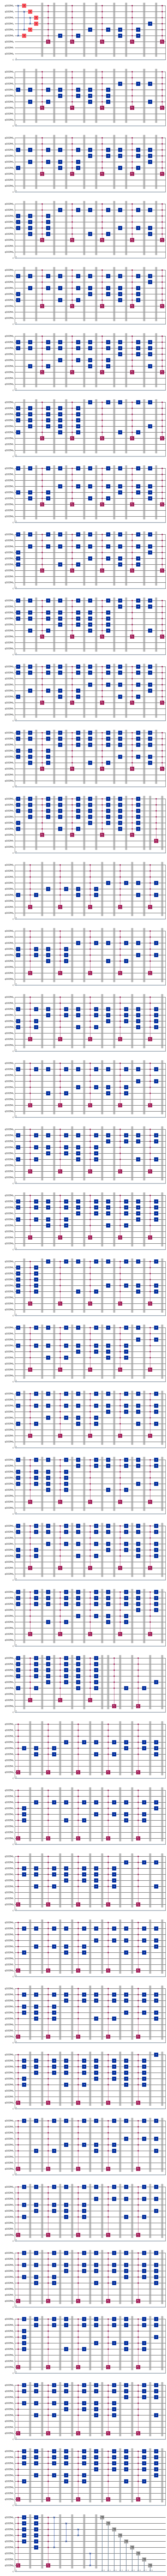

In [53]:
mcrqi = build_mcrqi(image)

mcrqi.draw(output='mpl')

## Scalability

We have the almost the same scaling as in the previous case. 

In [33]:
mcrqi_scaling = utils.plot_scalability(build_mcrqi, 3)

KeyboardInterrupt: 

In [ ]:
import csv

# Writing as a single row
with open('data/mcrqi.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(mcrqi_scaling)

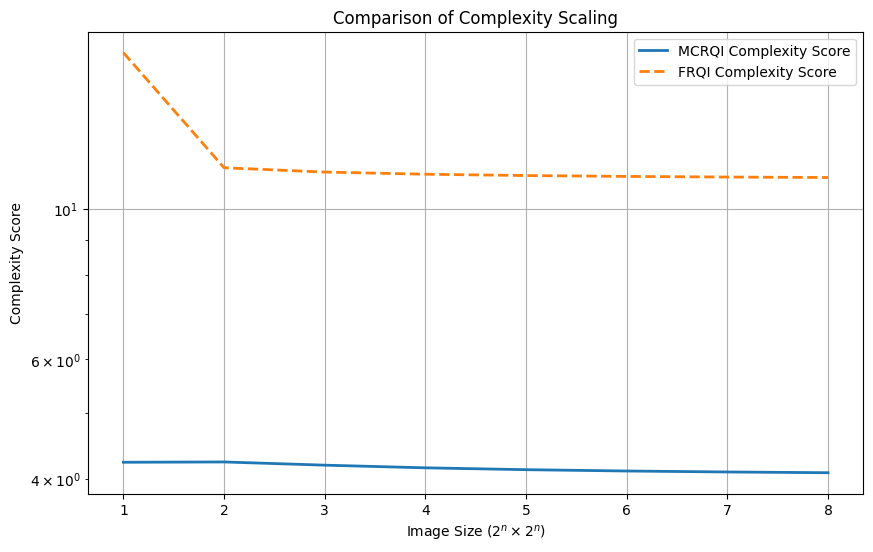

In [ ]:
utils.plot_complexity_scaling_comparison(mcrqi_scaling, "MCRQI",
                                         frqi_scaling, "FRQI", logscale=True)

Here we can see that we have almost the same complexity scaling despite MCRQI doing multichannel encoding! 

# QSMC-QSNC

TODO: USe multichannel image!

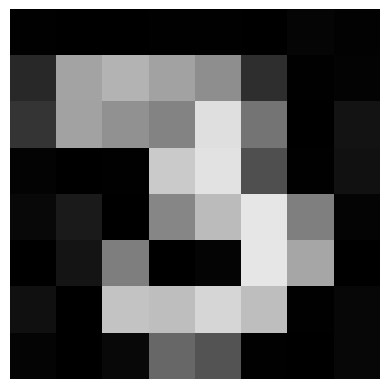

In [ ]:
image = utils.plot_image("images/three_8by8.jpg")

In [ ]:
n = int(log(image.shape[1], 2))

In [ ]:
def build_qsmc_qsnc(image):
    # Preparation
    flat_img = image.flatten()
    ### This is very inefficient if I understand it correctly.
    ###     - we are sorting a list just to find the idx of the biggest pixel value?
    idx_list = sorted(range(len(flat_img)), key=lambda k:flat_img[k])
    max_idx = max(idx_list) # this is only used to run the simulations
    ####
    
    thetas = utils.get_angle_representation(image)
    phis = np.interp(range(len(flat_img)), (0, len(flat_img)), (0, np.pi/2)) # TODO: make it simpler, these are coordinates
    
    O = qiskit.QuantumRegister(2*n, 'o_reg')

    color = qiskit.QuantumRegister(1,'color')
    coordinate = qiskit.QuantumRegister(1, 'coordinate')
    cr = qiskit.ClassicalRegister(O.size+color.size+coordinate.size, "cl_reg")

    qc = qiskit.QuantumCircuit(color, coordinate, O, cr)
    qc.h(O)
    controls = list(O)
    
    for i, (phi, theta) in enumerate(zip(phis, thetas)):
        qubit_index_bin = "{0:b}".format(i).zfill(n*2)
        
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc.x(O[k])
                
        qc.barrier()
        
        for coord_or_intns in (0,1):
            if not coord_or_intns: # if intensity -> value == 0
                #print(i, 'color')
                #print(theta)
                qc.mcry(theta=2*theta,
                            q_controls=controls,
                            q_target=color[0]) # mcry application to color target
            else: # if coordinate -> value == 1
                #print(i, 'coord')
                #print(phi)
                qc.mcry(theta=2*phi,
                            q_controls=controls,
                            q_target=coordinate[0]) # mcry application to coordinate target
        
        qc.barrier()
        
        if  i!=len(thetas) - 1:
            for k, qub_ind in enumerate(qubit_index_bin):
                if int(qub_ind):
                    qc.x(O[k])
                    
        qc.barrier()
    
    qc.measure(list(reversed(range(qc.num_qubits))), list(range(cr.size)))
        
    return qc

In [ ]:
qsmc_qsnc = build_qsmc_qsnc(image)
qsmc_qsnc.draw('mpl')

/Users/uribagi/Documents/PhD/CVC/quantum-representations-of-classical-data/qrep-env/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/uribagi/Documents/PhD/CVC/quantum-representations-of-classical-data/qrep-env/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


## Scalability

In [ ]:
qsmc_qsnc_scaling = utils.plot_scalability(build_qsmc_qsnc)

IndexError: list index out of range

In [ ]:
# Writing as a single row
with open('data/qsmc_qsnc.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(qsmc_qsnc_scaling)

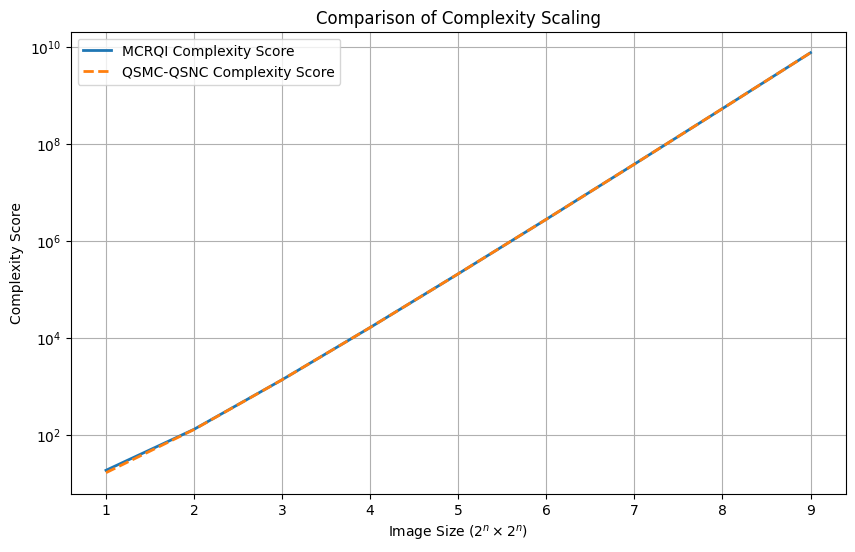

In [ ]:
utils.plot_complexity_scaling_comparison(mcrqi_scaling, "MCRQI",
                                         qsmc_qsnc_scaling, "QSMC-QSNC", logscale=True)

# OQIM

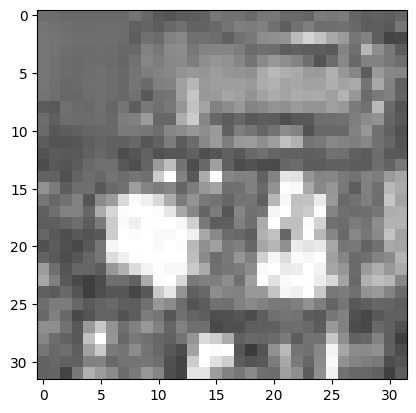

In [ ]:
image = utils.plot_image('images/three_8by8.jpg')

In [ ]:
def build_oqim(image):
    im_list = image.flatten()
    thetas = np.interp(im_list, (0, 256), (0, np.pi/2)) # intensity matrix
    phis = np.interp(range(len(im_list)), (0, len(im_list)), (0, np.pi/2)) # coordinate matrix
    num_ind_bits = int(np.ceil(log(len(im_list),2)))
    
    O = qiskit.QuantumRegister(num_ind_bits, 'o_reg')
    c = qiskit.QuantumRegister(1,'c_reg')
    p = qiskit.QuantumRegister(1, 'p_reg')
    cr = qiskit.ClassicalRegister(O.size+c.size+p.size, "cl_reg")
    qc = qiskit.QuantumCircuit(c, p, O, cr)
    num_qubits = qc.num_qubits
    input_im = image.copy().flatten()
    qc.id(c)
    qc.h(O)
    qc.h(p)

    controls = []
    for i, _ in enumerate(O):
        controls.extend([O[i]])
    for i, _ in enumerate(p):
        controls.extend([p[i]]) 
        
    for i, (phi, theta) in enumerate(zip(phis, thetas)):
        qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
        
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc.x(O[k])
        
        for coord_or_intns in (0,1):
            if not coord_or_intns:
                qc.mcry(theta=2*theta,
                            q_controls=controls,
                            q_target=c[0])
            else:
                qc.x(p)
                qc.mcry(theta=2*phi,
                            q_controls=controls,
                            q_target=c[0])
                if i!=len(thetas) - 1:
                    qc.x(p)
        
        if  i!=len(thetas) - 1:
            for k, qub_ind in enumerate(qubit_index_bin):
                if int(qub_ind):
                    qc.x(O[k])
            
    qc.measure(list(reversed(range(qc.num_qubits))), list(range(cr.size)))
    return qc
    

In [ ]:
oqim = build_oqim(image)
oqim.draw(output='mpl')

12
17346


## Scalability

In [ ]:
oqim_scaling = utils.plot_scalability(build_oqim)

In [ ]:
# Writing as a single row
with open('data/oqim.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(oqim_scaling)

# NEQR

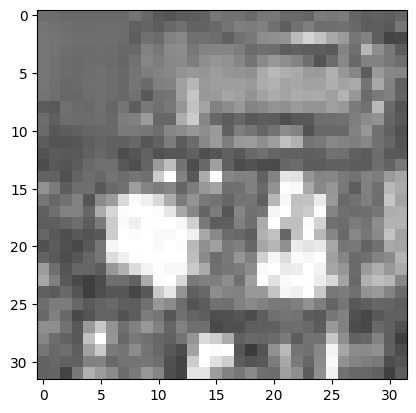

In [ ]:
image = utils.plot_image('images/three_8by8.jpg')

In [54]:
def build_neqr(image):
    w_bits = int(np.ceil(log(image.shape[1],2)))
    h_bits = int(np.ceil(log(image.shape[0],2)))
    indx = qiskit.QuantumRegister(w_bits+h_bits, 'indx')
    intensity = qiskit.QuantumRegister(8,'intensity')
    cr = qiskit.ClassicalRegister(len(indx)+len(intensity), 'cr')
    qc = qiskit.QuantumCircuit(intensity, indx, cr)
    num_qubits = qc.num_qubits
    input_im = image.copy().flatten()
    qc.id(intensity)
    qc.h(indx)
    for i, pixel in enumerate(input_im):
        pixel_bin = "{0:b}".format(pixel).zfill(len(intensity))
    position = "{0:b}".format(i).zfill(len(indx))
    for j, coord in enumerate(position):
        if int(coord): # valor es igual a 1
            qc.x(qc.num_qubits-j-1) # se aplica rotación en la posición correspondiente en los qubit index (se resta j pero nunca llega a menos de 8)
    for idx, px_value in enumerate(pixel_bin[::-1]): #recorre el valor codificado en binario invertido
        if(px_value=='1'):
            control_qubits = list(range(intensity.size, intensity.size + indx.size))
            target_qubit = intensity[idx]
            qc.mcx(control_qubits, target_qubit)
    if i!=len(input_im) - 1:
        for j, coord in enumerate(position):
            if int(coord):
                qc.x(qc.num_qubits-j-1)
    qc.barrier()
    qc.measure(range(qc.num_qubits),range(cr.size))
    
    return qc

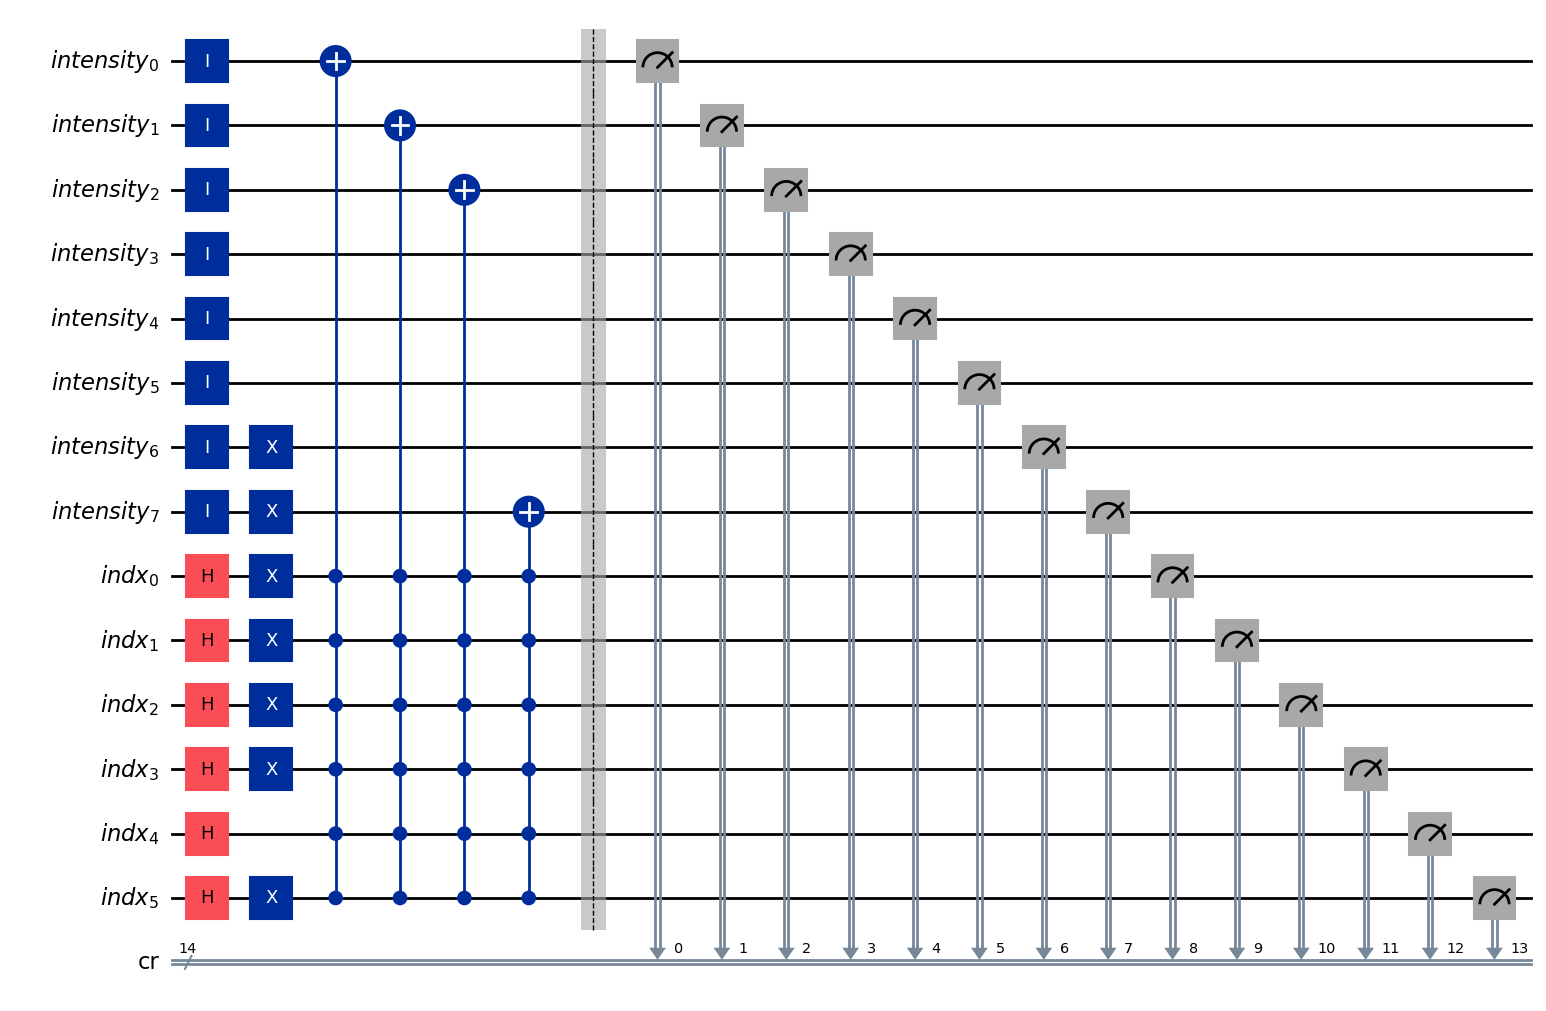

In [55]:
neqr = build_neqr(image)
neqr.draw(output='mpl')

## Scalability

In [ ]:
neqr_scaling = utils.plot_scalability(build_neqr)

In [ ]:
# Writing as a single row
with open('data/neqr.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(neqr_scaling)

# BRQI

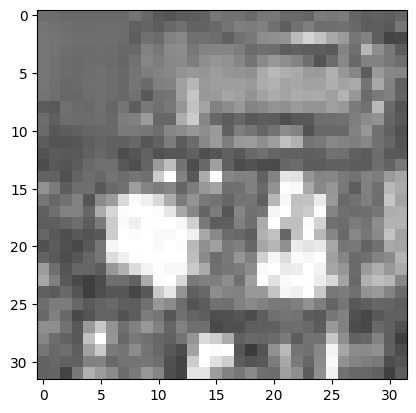

In [ ]:
image = utils.plot_image('images/three_8by8.jpg')

In [ ]:
def build_brqi(image):
    w_bits = int(np.ceil(log(image.shape[1],2)))
    h_bits = int(np.ceil(log(image.shape[0],2)))
    color_n_b = 8
    color_n_b = int(np.ceil(log(color_n_b,2)))

    color = qiskit.QuantumRegister(1, 'color')
    y_ax = qiskit.QuantumRegister(w_bits, 'y axis')
    x_ax = qiskit.QuantumRegister(h_bits, 'x axis')
    bitplane_q = qiskit.QuantumRegister(color_n_b, 'bitplanes')
    classic = qiskit.ClassicalRegister(1+w_bits+h_bits+color_n_b, 'classic')
    qc = qiskit.QuantumCircuit(color, y_ax, x_ax, bitplane_q, classic)

    qc.id(color)
    qc.h(x_ax)
    qc.h(y_ax)
    qc.h(bitplane_q)
    qc.barrier()
    for bitplane in range(8):
        bit_bitplane = "{0:b}".format(bitplane).zfill(color_n_b)
        for n, bit in enumerate(bit_bitplane):
            if bit!='1':
                qc.x(bitplane_q[n])
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                pixel = "{0:b}".format(int(image[i,j])).zfill(8)
                if pixel[bitplane]=='1':
                    i_bit = "{0:b}".format(i).zfill(h_bits)
                    for i_n, ibit in enumerate(i_bit):
                        if ibit!='1':
                            qc.x(x_ax[i_n])
                    j_bit = "{0:b}".format(j).zfill(w_bits)
                    for j_n, jbit in enumerate(j_bit):
                        if jbit!='1':
                            qc.x(y_ax[j_n])
                    qc.barrier()
                    controls = list(range(color.size, qc.num_qubits))
                    qc.mcx(controls, color)
                    for j_n, jbit in enumerate(j_bit):
                        if jbit!='1':
                            qc.x(y_ax[j_n])

                    for i_n, ibit in enumerate(i_bit):
                            if ibit!='1':
                                qc.x(x_ax[i_n])
                    qc.barrier()

        for n, bit in enumerate(bit_bitplane):
            if bit!='1':
                qc.x(bitplane_q[n])
    qc.barrier()
    qc.measure(list(reversed(range(qc.num_qubits))), list(range(classic.size)))
    
    return qc

In [ ]:
brqi = build_brqi(image)

brqi.draw(output='mpl')

14
13133


## Scalability

In [ ]:
brqi_scaling = utils.plot_scalability(build_brqi)

In [ ]:
# Writing as a single row
with open('data/brqi.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(brqi_scaling)

# GQRI

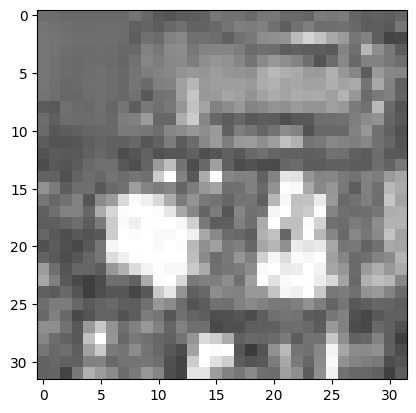

In [ ]:
image = utils.plot_image('images/three_8by8.jpg')

In [ ]:
def build_gqri(image):
    x = int(np.ceil(log(image.shape[0], 2)))
    if int(x) == 0: x = 1
    y = int(np.ceil(log(image.shape[1], 2)))
    if int(y) == 0: y = 1
    q = 8

    color = qiskit.QuantumRegister(q, 'color')
    y_ax = qiskit.QuantumRegister(y, 'y axis')
    x_ax = qiskit.QuantumRegister(x, 'x axis')
    classic = qiskit.ClassicalRegister(x+y+q, 'classic')
    qc = qiskit.QuantumCircuit(color, y_ax, x_ax, classic)

    qc.id(color)
    qc.h(x_ax)
    qc.h(y_ax)
    qc.barrier()
    controls_ = []
    for i, _ in enumerate(x_ax):
        controls_.extend([x_ax[i]])
    for i, _ in enumerate(y_ax):
        controls_.extend([y_ax[i]])
    for xi in range(image.shape[0]):
        xi_bin = "{0:b}".format(xi).zfill(x_ax.size)
        for i, bit in enumerate(xi_bin):
            if not int(bit):
                qc.x(x_ax[i])  
        qc.barrier()
        for yi in range(image.shape[1]):
            yi_bin = "{0:b}".format(yi).zfill(y_ax.size)
            for i, bit in enumerate(yi_bin):
                if not int(bit):
                    qc.x(y_ax[i]) 
            qc.barrier()
            intensity_bin = "{0:b}".format(image[xi, yi]).zfill(len(color))
            xg = qiskit.circuit.library.XGate(None).control(len(controls_))
            target = []
            for i, bit in enumerate(intensity_bin):
                if int(bit):
                    qc.mcx(controls_, color[i])
            qc.barrier()
            for i, bit in enumerate(yi_bin):
                if not int(bit):
                    qc.x(y_ax[i])
            qc.barrier()
        for i, bit in enumerate(xi_bin):
            if not int(bit):
                qc.x(x_ax[i])
        qc.barrier()

    qc.measure(x_ax, range(x_ax.size))
    qc.measure(y_ax, range(x_ax.size, x_ax.size+y_ax.size))
    qc.measure(color, range(x_ax.size+y_ax.size,x_ax.size+y_ax.size+color.size))
    return qc

In [ ]:
gqri = build_gqri(image)
gqri.draw(output='mpl')

## Scalability

In [ ]:
grqi_scaling = utils.plot_scalability(build_grqi)

In [ ]:
# Writing as a single row
with open('data/grqi.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(grqi_scaling)